## Using features extracted from intensity profiles
## PCA and Density-Based Spatial Clustering of Applications with Noise applied to features

In [ ]:
!pip install adjustText

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from seaborn import scatterplot
from scipy.signal import savgol_filter
from adjustText import adjust_text

In [ ]:
import matplotlib.pylab as pylab
params = {
    'font.size': 12,
    'legend.fontsize':'large',
    'figure.titlesize':'large',
    'axes.grid':False,
    'axes.labelsize':'large',
    'axes.titlesize':'large',
    'xtick.labelsize':'large',
    'ytick.labelsize':'large',
    #'figure.figsize': (5, 6)
    }
pylab.rcParams.update(params)

In [ ]:
def get_loading_scores(pca_component):
    loading_scores = pd.Series(pca.components_[pca_component],index=indices)
    sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
    #print(sorted_loading_scores.index.values)
    print(sorted_loading_scores)
    print(f'\nsum of loading scores = {sum(sorted_loading_scores**2):.6f}')
    print(f'\nRelevant attributes for PC{pca_component+1}:{sorted_loading_scores[sorted_loading_scores>np.sqrt(1/len(attributes_df.columns))].index.values.astype(str).tolist()}')
    print(f'==============================================')
    return

def scree_plot(percent_variation):
    labels = ['PC' + str(x) for x in range(1, len(percent_variation)+1)]
    fig, ax =  plt.subplots(figsize=(8, 6))
    ax.bar(labels, percent_variation, color = 'lightskyblue', alpha=1)
    ax.plot(labels, percent_variation, color='salmon', marker='.', linestyle='--')
    ax.set_xlabel('Principal component')
    ax.set_ylabel('Percentage variation')
    for p in ax.patches:
        ax.annotate(str(int(np.round(p.get_height())))+'%', (p.get_x()+p.get_width()/2, p.get_height()),
                    ha='center', va='center',
                    size=14, xytext=(0, 8), textcoords='offset points')

    strings = ['E, B, D, F',
              'A, C, G',
              'B, F, E']
    for i in range(3):
        p = ax.patches[i]
        ax.annotate(strings[i], (p.get_x()+p.get_width()/2, p.get_height()),
                    ha='center', va='top',
                    size='large', xytext=(0, -10), textcoords='offset points', rotation=90,
                    bbox=dict(boxstyle='round', fc='aliceblue', ec="k", lw=1))
    ax.annotate('Strongly correlating\nattributes',
                (5, 45), ha='center', va='center', size='large',
                bbox=dict(boxstyle='round', fc='aliceblue', ec="k", lw=1))
    ax.annotate(legend_annotations, (4.2, 33), ha='left', va='center', size='large')
    plt.tight_layout()
    plt.show()
    return

def plot_pca(pca_df, x_axis='PC1', y_axis='PC2', data=''):
    fig, ax = plt.subplots(figsize=(6, 6))
    # Define color and marker mapping
    if data == 'experiment': # plaques 1-8
        marker_map = {
            range(0, 20): ('*', 'black', '1'),
            range(20, 34): ('o', 'blue', '2'),
            range(34, 49): ('<', 'green', '3'),
            range(49, 73): ('D', 'red', '4'),
            range(73, 86): ('X', 'cyan', '5'),
            range(86, 94): ('s', 'magenta', '6'),
            range(94, 117): ('^', 'gray', '7'),
            range(117, len(scaled_data)): ('p', 'purple', '8')
        }
        round_one_cells = [0, 20, 34, 49, 73, 86, 94, 117]
    elif data == 'toy-similar': # similar toy data
        marker_map = {
            range(0, 10): ('*', 'black', '1'),
            range(10, 20): ('o', 'blue', '2'),
            range(20, 30): ('<', 'green', '3'),
            range(30, 40): ('D', 'red', '4')
        }
        round_one_cells = [0, 10, 20, 30]
    elif data =='toy-dissimilar': # dissimilar toy data
        marker_map = {
            range(0, 11): ('*', 'black', '1'),
            range(11, 24): ('o', 'blue', '2'),
            range(24, 31): ('<', 'green', '3'),
            range(31, 37): ('D', 'red', '4'),
            range(37, 47): ('X', 'cyan', '5'),
            range(47, 56): ('s', 'magenta', '6'),
        }
        round_one_cells = [0, 11, 24, 31, 37, 47]

    for index_range, (marker, color, plaque_num) in marker_map.items():
        ax.scatter([], [], marker=marker, c=color, label=f'{plaque_num}')


    for cell_number in pca_df.index:
        for index_range, (marker, color, _) in marker_map.items():
            if cell_number + 1 in index_range:
                ax.scatter(pca_df[x_axis][cell_number], pca_df[y_axis][cell_number], marker=marker, c=color)
                break

    for round_one_cell in round_one_cells:
        ax.scatter(pca_df[x_axis].loc[round_one_cell], pca_df[y_axis].loc[round_one_cell], s=100, facecolors='none', edgecolors='k')
        ax.annotate(f'P{round_one_cells.index(round_one_cell)+1}C1',
                    (pca_df[x_axis].loc[round_one_cell], pca_df[y_axis].loc[round_one_cell] - 0.1),
                    ha='center', va='top', size='medium')

    ax.set_xlabel(x_axis)
    ax.set_ylabel(y_axis)
    ax.legend(title='Plaque #', loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=False, shadow=False, ncol=8)
    plt.tight_layout()
    plt.legend()
    plt.show()
    return


def plot_pca_dbscan(pca_df_copy, x_axis='', y_axis=''):
    fig, ax = plt.subplots(figsize=(6, 6))
    if data == 'experiment': # plaques 1-8
        marker_map = {
            range(0, 20): ('*', 'black', '1'),
            range(20, 34): ('o', 'blue', '2'),
            range(34, 49): ('<', 'green', '3'),
            range(49, 73): ('D', 'red', '4'),
            range(73, 86): ('X', 'cyan', '5'),
            range(86, 94): ('s', 'magenta', '6'),
            range(94, 117): ('^', 'gray', '7'),
            range(117, len(scaled_data)): ('p', 'purple', '8')
        }
        round_one_cells = [0, 20, 34, 49, 73, 86, 94, 117]
    elif data == 'toy-similar': # similar toy data
        marker_map = {
            range(0, 10): ('*', 'black', '1'),
            range(10, 20): ('o', 'blue', '2'),
            range(20, 30): ('<', 'green', '3'),
            range(30, 40): ('D', 'red', '4')
        }
        round_one_cells = [0, 10, 20, 30]
    elif data =='toy-dissimilar': # dissimilar toy data
        marker_map = {
            range(0, 11): ('*', 'black', '1'),
            range(11, 24): ('o', 'blue', '2'),
            range(24, 31): ('<', 'green', '3'),
            range(31, 37): ('D', 'red', '4'),
            range(37, 47): ('X', 'cyan', '5'),
            range(47, 56): ('s', 'magenta', '6'),
        }
        round_one_cells = [0, 11, 24, 31, 37, 47]

    annot = []
    xs = []
    ys = []
    texts = []
    unique_clusters = pca_df_copy['Cluster'].unique()
    num_clusters = len(unique_clusters)
    color_palette = sns.color_palette('magma', num_clusters)
    ax = sns.scatterplot(x=x_axis, y=y_axis, data=pca_df_copy, style='Plaque', s=75, ec=None, hue='Cluster', palette=color_palette)
    for round_one_cell in round_one_cells:
        xs.append(pca_df_copy[x_axis].loc[round_one_cell])
        ys.append(pca_df_copy[y_axis].loc[round_one_cell])
        annot.append(f'P{round_one_cells.index(round_one_cell) + 1}C1')
        ax.scatter(pca_df_copy[x_axis].loc[round_one_cell], pca_df_copy[y_axis].loc[round_one_cell], s=150, facecolors='none',
                    edgecolors='k')
    for x, y, s in zip(xs, ys, annot):
        texts.append(plt.text(x, y, s))
    ax.set_xlabel(x_axis)
    ax.set_ylabel(y_axis)
    adjust_text(texts, only_move={'points':'y', 'texts':'y'}, expand=(1.2, 2), arrowprops=dict(arrowstyle="->", color='k', lw=1.))
    plt.legend(loc='upper center', labelspacing=0.1, bbox_to_anchor=(0.5, -0.1), ncol=4, fancybox=False, shadow=False)
    plt.show()
    return

PCs 1,2,3 percent varitation: 92.2412932427149


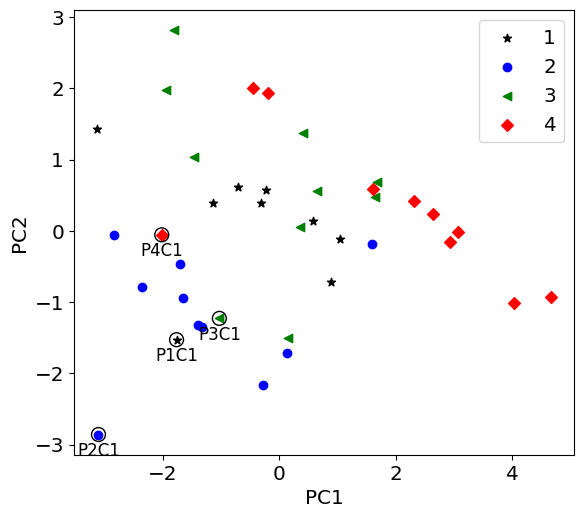

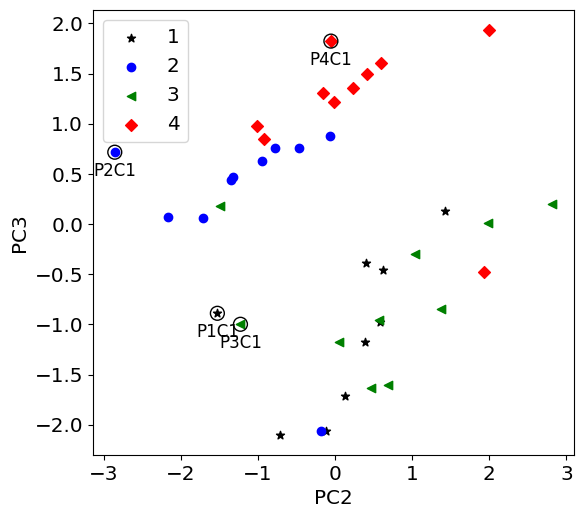

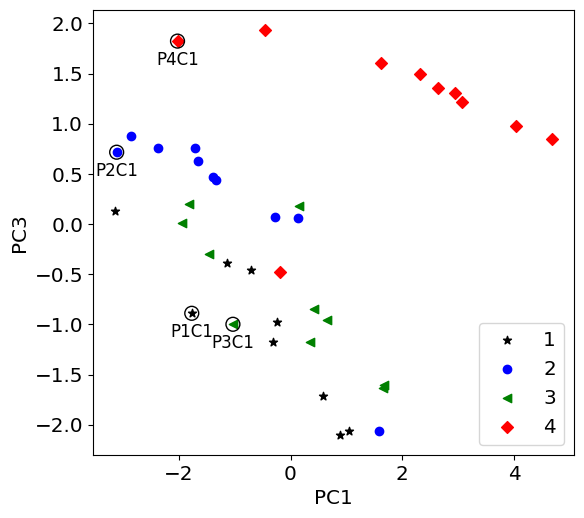

In [ ]:
# file_name = 'experimental data - attributes.xlsx'
# sheet_name = 'all plaques'
# n_rows = 153
# data = 'experiment'

# file_name = 'S1.xlsx'
# sheet_name = 'attributes'
# n_rows = 40
# data = 'toy-similar'

file_name = 'S2.xlsx'
sheet_name = 'attributes'
n_rows = 40
data = 'toy-similar'

# file_name = 'S3.xlsx'
# sheet_name = 'attributes'
# n_rows = 56
# data = 'toy-dissimilar'

attributes_df = pd.read_excel(file_name, sheet_name, nrows=n_rows)
attributes_df = attributes_df.drop(labels=['Unnamed: 0', 'Cell #', 'Plaque', 'Cell ID'], axis=1)
indices = ['GFP max', 'Infection time', 'Rise time', 'Lysis time', 'Infection duration', 'Rise rate', 'Area']
columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7']
legend_annotations = 'A - Area\nB - Infection time\nC - GFP max\nD - Infection duration\nE - Lysis time\nF - Rise rate\nG - Rise time'
n_features = 7

scaled_data = StandardScaler().fit_transform(attributes_df)
#pd.DataFrame(scaled_data, columns=attributes_df.columns)

pca = PCA()
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
pca_df = pd.DataFrame(pca_data, columns=columns)
percent_variation = pca.explained_variance_ratio_*100

# print(f'\nAttribute is important if loading score > {np.sqrt(1/n_features):.6f}')
# print(f'--------------------------------------------\n')
# get_loading_scores(0)
# get_loading_scores(1)
# get_loading_scores(2)
# scree_plot(percent_variation)

print(f'PCs 1,2,3 percent varitation: {np.sum(percent_variation[0:3])}')
plot_pca(pca_df, x_axis='PC1', y_axis='PC2', data=data)
plot_pca(pca_df, x_axis='PC2', y_axis='PC3', data=data)
plot_pca(pca_df, x_axis='PC1', y_axis='PC3', data=data)

## PCA-DBSCAN

In [ ]:
pca_df = pca_df.drop(labels=['PC4', 'PC5', 'PC6', 'PC7'], axis=1)

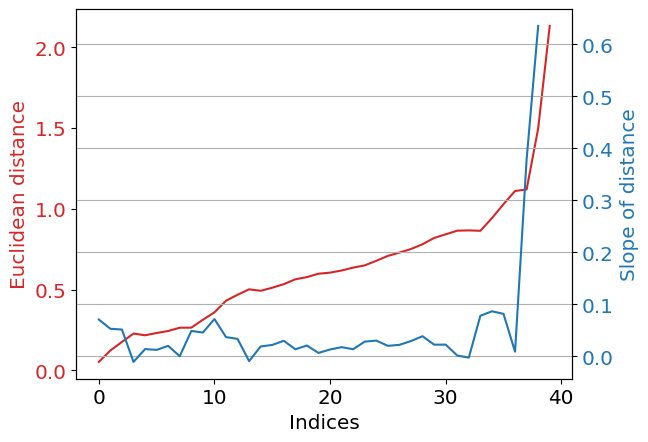

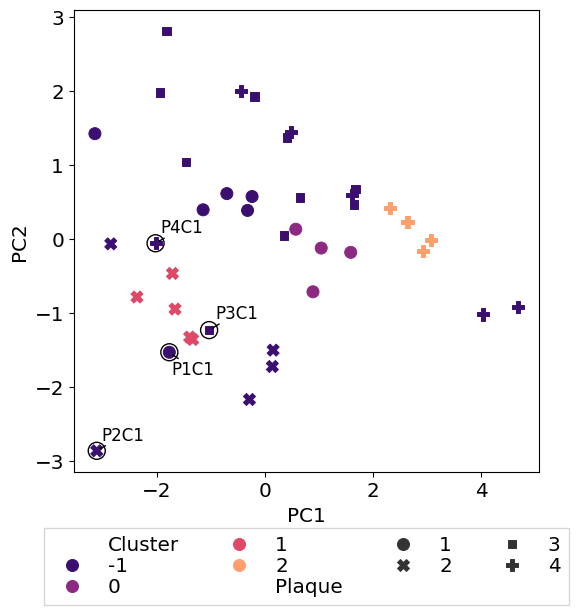

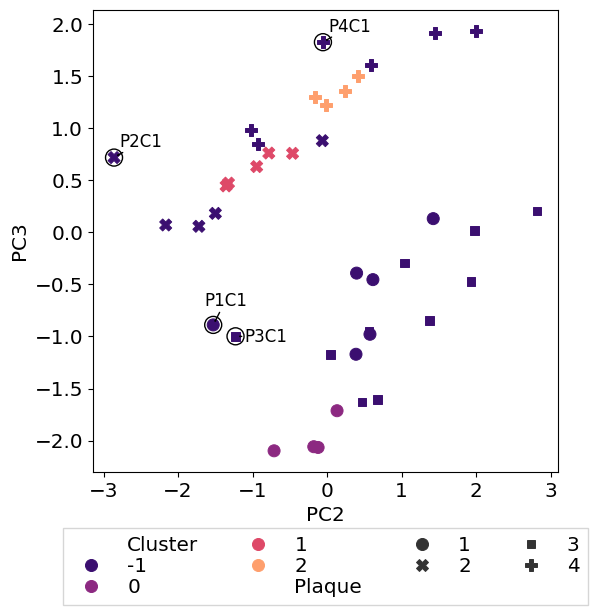

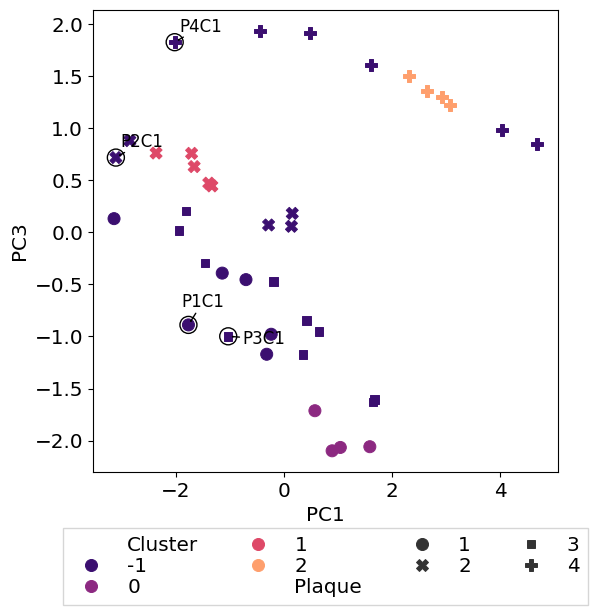

Cluster
-1    27
 1     5
 0     4
 2     4
Name: count, dtype: int64


In [ ]:
n_neighbors = 4
eps = 0.75#1.10 # 0.85 # 1.25
neighbors = NearestNeighbors(n_neighbors=n_neighbors)
neighbors_fit = neighbors.fit(pca_df)
distances, indices = neighbors_fit.kneighbors(pca_df)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Indices')
ax1.set_ylabel('Euclidean distance', color=color)
#ax1.plot(distances, ls='--', color=color)
smoothed_distances = savgol_filter(distances, window_length=5, polyorder=2)
ax1.plot(smoothed_distances, ls='-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Slope of distance', color=color)
ax2.plot(np.diff(smoothed_distances), color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.grid()
plt.show()

clustering = DBSCAN(eps=eps, min_samples=n_neighbors).fit(pca_df)

original_df = pd.read_excel(file_name, sheet_name, nrows=n_rows)
original_df = original_df.drop(labels=['Unnamed: 0'], axis=1)
pca_df_copy = pca_df.copy()
pca_df_copy['Cell #'] = original_df['Cell #']
pca_df_copy['Plaque'] = original_df['Plaque']
pca_df_copy['Cell ID'] = original_df['Cell ID']
pca_df_copy['Cluster'] = clustering.labels_
plaque_markers_dict = {1: '*',2: 'o',3: '<',4: 'D',5: 'X',6: 's',7: '^',8: 'p'}
pca_df_copy['Plaque marker'] = pca_df_copy['Plaque'].map(plaque_markers_dict)

plot_pca_dbscan(pca_df_copy, x_axis='PC1', y_axis='PC2')
plot_pca_dbscan(pca_df_copy, x_axis='PC2', y_axis='PC3')
plot_pca_dbscan(pca_df_copy, x_axis='PC1', y_axis='PC3')
print(pca_df_copy['Cluster'].value_counts())